# Project Part 2 Solutions

## (a)

In [198]:
import numpy as np

file=np.load("part2.npz")
beta_old=file['beta_old']
N=file['N']
Svc_0_PMF=file['Svc_0_PMF']
Lc=file['Lc']
Ic_0=file['Ic_0']
gamma=file['gamma']
L_observed=file['L_observed']
nb_nodes = Svc_0_PMF.shape[0]

In [199]:
def SIR(t, Z, N, betas, gamma):
    (S_vec, I_vec, R) = (Z[:16].reshape(4, 4), Z[16:20], Z[-1])
    I = I_vec.sum()
    dSdt = -betas*S_vec*I/N 
    dIdt = -dSdt.sum(axis=0)-gamma*I_vec
    dRdt = np.array([gamma*I])
    return np.concatenate((dSdt.flatten(), dIdt, dRdt))

In [220]:
from scipy.integrate import solve_ivp
from scipy.optimize import fmin
from sklearn.metrics import mean_squared_error

Svc_0_PMF /= Svc_0_PMF.sum(axis=(1, 2), keepdims=True)
Svc_0 = (N-Ic_0.sum(axis=1))[:, np.newaxis, np.newaxis]*Svc_0_PMF
Svc_0 = Svc_0.round().astype(int)
R0 = np.zeros((nb_nodes)).astype(int)

t = np.linspace(0, 199, 200)

S = np.zeros((nb_nodes, 4, 4, len(t)))
I = np.zeros((nb_nodes, 4, len(t)))
R = np.zeros((nb_nodes, len(t)))
L = np.zeros((nb_nodes, len(t)))

for N_node, node_index in zip(N, range(nb_nodes)):

    initial_conditions = np.concatenate(
        (Svc_0[node_index].flatten(), Ic_0[node_index], [R0[node_index]]))

    soln = solve_ivp(
        SIR, (t[0], t[9]), initial_conditions, args=(N_node, beta_old, gamma), t_eval=t[:10])

    S[node_index, :, :, :10] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, :10] = soln.y[16:20]
    R[node_index, :10] = soln.y[20]
    L[node_index, :10] = Lc@soln.y[16:20]


alpha_predicted = np.zeros((nb_nodes))

def loss_func(alpha):
    ###### WRITE YOUR FUNCTION HERE
    Z = np.concatenate((S[node_index,:,:,9].flatten(), I[node_index,:,9], [R[node_index,9]]))
    beta_new = beta_old * alpha
    soln = solve_ivp(
        SIR, (t[9], t[30]), Z, args=(N_node, beta_new, gamma), t_eval=t[9:30])
    
    S[node_index, :, :, 9:30] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, 9:30] = soln.y[16:20]
    R[node_index, 9:30] = soln.y[20]
    L[node_index, 9:30] = Lc@soln.y[16:20]
    mse = mean_squared_error(L[node_index, 9:30], L_observed[node_index][9:30])
    
    return mse

for N_node, node_index in zip(N, range(nb_nodes)):
    alpha_predicted[node_index] = fmin(loss_func, 0.5, disp=False)

print("Sorted alpha values: ",'\n\n', np.sort(alpha_predicted),'\n')
sorted_indexes = np.argsort(alpha_predicted)
print("Indexes of nodes sorted by alpha values ", '\n\n', sorted_indexes)

Sorted alpha values:  

 [0.13437347 0.14959717 0.15996704 0.16158829 0.16306152 0.16851807
 0.17086182 0.17155762 0.17612305 0.17961426 0.18221436 0.18603516
 0.18710937 0.19025879 0.20031738 0.20330505 0.20419922 0.20612793
 0.20684509 0.2128418  0.21408691 0.2162323  0.21859131 0.22739258
 0.23042603 0.23352203 0.24157715 0.24465332 0.24894104 0.25119629
 0.25798035 0.25991821 0.26757812 0.26948242 0.27169952 0.27301636
 0.28005524 0.28283691 0.28662109 0.28800049 0.2930542  0.2992981
 0.29938354 0.30321045 0.30422821 0.30437317 0.30966797 0.31420898
 0.32382202 0.3296875  0.32988281 0.33074341 0.33313293 0.33355408
 0.3498291  0.35234375 0.35657806 0.35756836 0.35844421 0.36207275
 0.36960449 0.37071838 0.37946777 0.38393707 0.3860054  0.39033203
 0.40922546 0.41445465 0.41787415 0.41876221 0.42476807 0.43438721
 0.43756104 0.44870605 0.44996338 0.45647888 0.47091064 0.48615723
 0.5023941  0.50705566 0.50830688 0.52108459 0.53604736 0.55296021
 0.55423279 0.56278687 0.58075714 0.59

## (b)

In [187]:
def g(money):
    alpha = 1/np.log2(2*10**(-3)*money+2)
    return alpha

def g_inv(alpha):
    money = (2**(1/alpha)-2)/(2*10**(-3))
    return money

def calc_alpha(alpha_own, npi):
    return g(g_inv(alpha_own) + npi)

import matplotlib.pyplot as plt 

def scatter_plot(alpha_afterNPI):
    plt.figure()
    colors=(beta_old[np.newaxis,:,:]*Svc_0_PMF).mean(axis=(1,2))
    plt.scatter(alpha_predicted, alpha_afterNPI, s=N/500, c=colors, cmap='jet', alpha=0.5)
    plt.xlabel(r"$\alpha_{own}$")
    plt.ylabel(r"$\alpha_{after\ NPI}$")

def total_recovered_difference(alpha_afterNPI):
    
    # Difference in total recovered after day 200. Idea: solve_ivp and get recovered at day 200 with 
    # first alpha and then with second alpha. Compute difference
    difference = 0
    for N_node, node_index in zip(N, range(nb_nodes)):

        Z = np.concatenate((S[node_index,:,:,29].flatten(), I[node_index,:,29], [R[node_index,29]]))
        beta = beta_old * alpha_predicted[node_index]
        soln = solve_ivp(
            SIR, (t[29], t[199]), Z, args=(N_node, beta, gamma), t_eval=t[29:199])

        beta = beta_old * alpha_afterNPI[node_index]
        soln_after = solve_ivp(
            SIR, (t[29], t[199]), Z, args=(N_node, beta, gamma), t_eval=t[29:199])
        
        difference += soln_after.y[-1][-1] - soln.y[-1][-1] # first [-1] should pick the recovered people, second should pick last day
    return difference

### Policy #1

i.

ii.

The policy 1 total recovered diference:  -320300.825697052


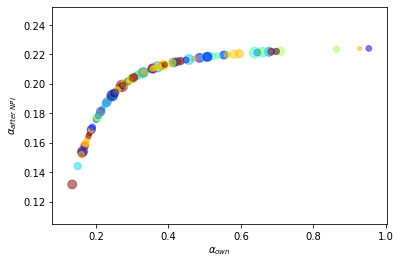

In [194]:
import copy
alpha_after_policy1 = copy.deepcopy(alpha_predicted)
for index, value in enumerate(alpha_predicted):
    alpha_after_policy1[index] = calc_alpha(value, 10000) # We are spending same amount of money in each node, so 10000 per node

scatter_plot(alpha_after_policy1)
print("The policy {} total recovered diference: ".format(1), total_recovered_difference(alpha_after_policy1))

### Policy #2

i. 

ii.

The policy 2 total recovered diference:  -335846.7291849523


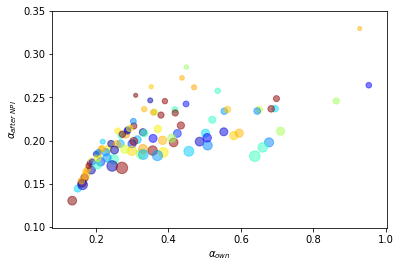

In [196]:
budget = 1000000 # Total to spend
N_proportional = N/N.sum()
alpha_after_policy2 = copy.deepcopy(alpha_predicted)

for index, value in enumerate(alpha_predicted):
    alpha_after_policy2[index] = calc_alpha(value, N_proportional[index]*budget) # We are spending same amount of money in each node, so 10000 per node

scatter_plot(alpha_after_policy2)
print("The policy {} total recovered diference: ".format(2), total_recovered_difference(alpha_after_policy2))

### Policy #3

i.

ii.

The policy 3 total recovered diference:  -62723.05379041414


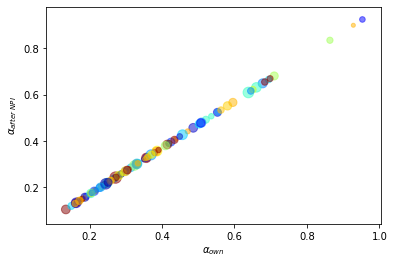

In [192]:
def difference_budget(delta_alpha):
    # Go over every alpha and compute money needed to produce given delta alpha
    money_needed = 0
    budget = 1000000
    for alpha in alpha_predicted:
        money_needed += g_inv(alpha-delta_alpha) - g_inv(alpha)
    
    return (money_needed - budget) ** 2 # squared so that we minimize a positive value!

delta_alpha = fmin(difference_budget, 0, disp=False)

alpha_after_policy3 = copy.deepcopy(alpha_predicted)
for index, value in enumerate(alpha_predicted):
    alpha_after_policy3[index] = value - delta_alpha

scatter_plot(alpha_after_policy3)
print("The policy {} total recovered diference: ".format(3),total_recovered_difference(alpha_after_policy3))

### Policy #4

i.

ii.

The policy 4 total recovered diference:  -323620.75059702405


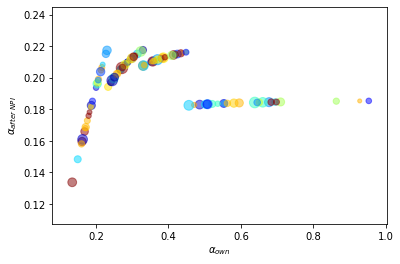

In [215]:
# Spend money proportional to alphas.
# Idea: will get the 25 worst alphas, and spend 50% of the money on those distributed equally
# We will get the 25 next worst alphas, and spend 25% of money distributed equally
# next 25%: spend 20% of the money distributed equally
# last 25%: spend last 5% of money

sorted_indexes
first_group = sorted_indexes[75:] # Group where we will spend more money
second_group = sorted_indexes[50:75]
third_group = sorted_indexes[25:50]
last_group = sorted_indexes[:25] # Group where we will spend less money

alpha_after_policy4 = copy.deepcopy(alpha_predicted)

# Compute budget we will spend on each node of each group

budget_first = budget*.5/25
budget_second = budget*.25/25
budget_third = budget*.20/25
budget_last = budget*.05/25

# Compute new Alphas 

for node_ind in first_group:
    alpha_after_policy4[node_ind] = calc_alpha(alpha_predicted[node_ind], budget_first)
for node_ind in second_group:
    alpha_after_policy4[node_ind] = calc_alpha(alpha_predicted[node_ind], budget_second)
for node_ind in third_group:
    alpha_after_policy4[node_ind] = calc_alpha(alpha_predicted[node_ind], budget_third)
for node_ind in last_group:
    alpha_after_policy4[node_ind] = calc_alpha(alpha_predicted[node_ind], budget_last)

scatter_plot(alpha_after_policy4)
print("The policy {} total recovered diference: ".format(4),total_recovered_difference(alpha_after_policy4))

## (c)

### Policy 1

### Policy 2

### Policy 3

### Policy 4